In [2]:
#Imports
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage, misc

# SK-Learn
from skimage.feature import hog
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#Image Directory
train_dir = 'D:data/train/'
test_dir = 'D:data/test/'

In [3]:
#Count the number of images in the different categories in training and test set
row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


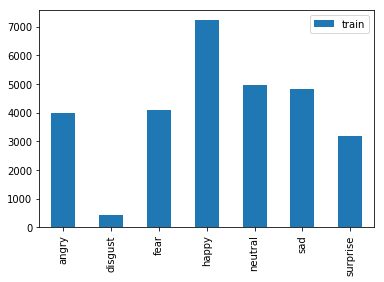

In [4]:
#Plot number of images in training set
train_count.transpose().plot(kind='bar')

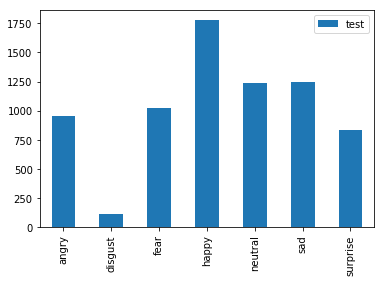

In [5]:
#Plot number of images in test set 
test_count.transpose().plot(kind='bar')

In [6]:
#Import pictures
def load_images_from_folder(folder):
    #create an integer value for each of 7 categories
    class_names = os.listdir(folder) # Get names of classes
    class_name2id = { label: index for index, label in enumerate(class_names) } # Map class names to integer labels

    images, labels = [], []
    for expression in os.listdir(folder):
        path = folder + expression
        label_id = class_name2id[expression]
      
        for filename in os.listdir(path):
            img = cv2.imread(path + '/' +filename)

            if img is not None:
                images.append(img)
                labels.append(label_id)
    return images, labels

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


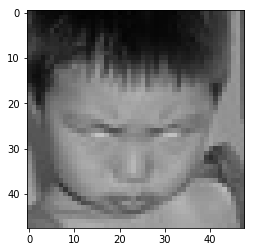

In [7]:
class_names = os.listdir(train_dir) # Get names of classes
class_name2id = { label: index for index, label in enumerate(class_names) } # Map class names to integer labels

print(class_names)

training, labels_training = load_images_from_folder(train_dir)
testing, labels_testing = load_images_from_folder(test_dir)

#Display first image in training data
img = training[0]
imgplot = plt.imshow(img)
plt.show()

## Preprocessing

In [9]:
#Method to perform equalization histogram on a list of images
def equalizing(images):
    equ_hist_images = []
    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        equ = cv2.equalizeHist(img)
        equ_hist_images.append(equ)
    return equ_hist_images
#inputs a list of images and the filtervalue (often 3)
#outputs a new list of images with the median filter applied
def apply_median_filter(images, filter_value): 
    images_med = []
    for img in images:
        img_med = ndimage.median_filter(img, filter_value)
        images_med.append(img_med)
    return images_med

training_equalized = equalizing(training)
testing_equalized = equalizing(testing)

training_equ_med = apply_median_filter(training_equalized, 3)
testing_equ_med = apply_median_filter(testing_equalized, 3)

## Feature Extraction - HoG

In [10]:
#Caculate HoG for every image in data

hog_features_training = np.asarray([hog(image_training, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2)) for image_training in training])
hog_features_test = np.asarray([hog(image_test, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2)) for image_test in testing])

#print shape
print(hog_features_training.shape)
print(hog_features_test.shape)

D:\software\anaconda\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


(28709, 900)
(7178, 900)


In [11]:
#Split up into training and test 
X_trn_hog = hog_features_training
Y_trn = labels_training 

X_test_hog = hog_features_test
Y_test = labels_testing 

## Linear SVM

HoG Accuracy: 0.44483142936751185


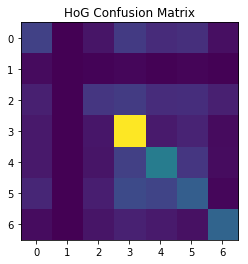

In [13]:
#Linear SVM
# create SVM models
svm_hog = svm.SVC(kernel='linear', gamma='scale')

# train SVM models
svm_hog.fit(X_trn_hog, Y_trn)

# evaluate SVM models with the confusion matrix and with accuracy
hog_predictions = svm_hog.predict(X_test_hog)
print('HoG Accuracy: {}'.format(accuracy_score(Y_test, hog_predictions))) 
plt.subplot(111), plt.imshow(confusion_matrix(Y_test, hog_predictions)), plt.title('HoG Confusion Matrix')
plt.show()

## Random Forest

In [14]:
def randomForest(nbr_estimators_list):
    for nbr_estimator in nbr_estimators_list:
        # create random forest classifier
        rf = RandomForestClassifier(n_estimators=nbr_estimator, criterion='entropy')

        # train classifier
        rf.fit(X_trn_hog, Y_trn)

        # evaluate classifier performance
        rf_predictions = rf.predict(X_test_hog)
        print('Random Forest Accuracy: {}'.format(accuracy_score(Y_test, rf_predictions)))
        plt.imshow(confusion_matrix(Y_test, rf_predictions)), plt.title('Random Forest Confusion Matrix')
        plt.show()

Random Forest Accuracy: 0.4601560323209808


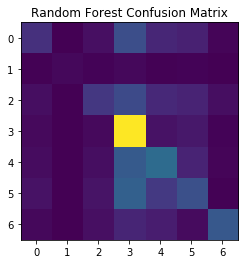

Random Forest Accuracy: 0.4679576483700195


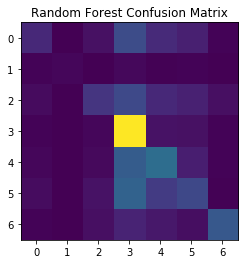

Random Forest Accuracy: 0.4772917247144051


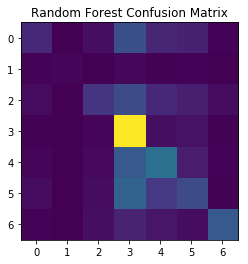

Random Forest Accuracy: 0.47757035385901364


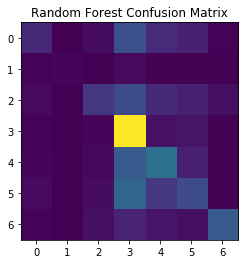

Random Forest Accuracy: 0.4779882975759264


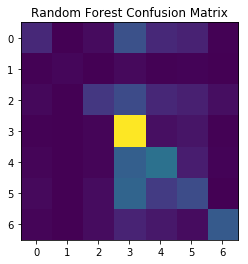

Random Forest Accuracy: 0.4786848704374478


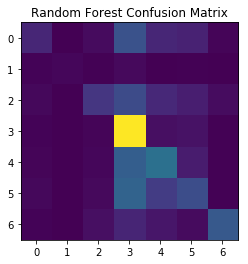

In [16]:
nbr_estimators_list = [100, 200, 300, 400, 500, 1000]
randomForest(nbr_estimators_list)

## Comparison of Classifiers

SVM RBF Training Set Accuracy: 0.4787348914974398
Random Forest 1000-tree Training Set Accuracy: 0.9985022118499425


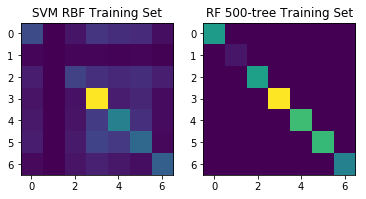

[[-2709     0   308   840   710   653   198]
 [  103  -435    69    81    52    97    33]
 [  438    -1 -3002   753   638   714   460]
 [  294     0   265 -1718   418   581   160]
 [  379     0   296   967 -2569   758   169]
 [  444     0   400  1106   919 -2996   127]
 [  144     0   296   499   352   202 -1493]]


In [21]:
#Performance Analysis

# predictions on training set for both classifiers
svm_linear = svm_hog.predict(X_trn_hog)

# create random forest classifier
rf = RandomForestClassifier(n_estimators=500, criterion='entropy')

# train classifier
rf.fit(X_trn_hog, Y_trn)

# evaluate classifier performance on train dataset
rf_predictions = rf.predict(X_trn_hog)

print('SVM RBF Training Set Accuracy: {}'.format(accuracy_score(Y_trn, svm_linear)))
print('Random Forest 1000-tree Training Set Accuracy: {}'.format(accuracy_score(Y_trn, rf_predictions)))
plt.subplot(121), plt.imshow(confusion_matrix(Y_trn, svm_linear)), plt.title('SVM RBF Training Set')
plt.subplot(122), plt.imshow(confusion_matrix(Y_trn, rf_predictions)), plt.title('RF 500-tree Training Set')
plt.show()

# compare confusion matrices
print(np.subtract(confusion_matrix(Y_trn, svm_linear), confusion_matrix(Y_trn, rf_predictions)))

D:\software\anaconda\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


SVM-Linear Accuracy with cellsize=6, blocksize=1, orientationbins=8: 0.42407355809417663
RF 500-tree Accuracy with cellsize=6, blocksize=1, orientationbins=8: 0.4395374756199498


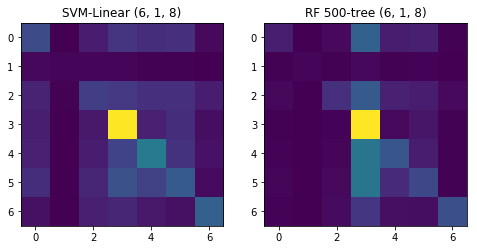

D:\software\anaconda\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


SVM-Linear Accuracy with cellsize=6, blocksize=1, orientationbins=9: 0.4224017832265255
RF 500-tree Accuracy with cellsize=6, blocksize=1, orientationbins=9: 0.4320144887155196


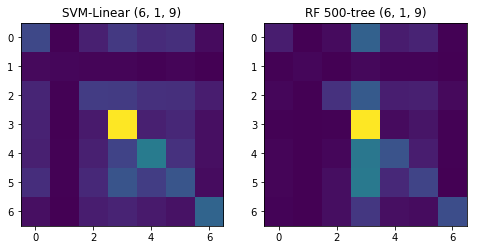

D:\software\anaconda\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


SVM-Linear Accuracy with cellsize=6, blocksize=1, orientationbins=10: 0.4182223460573976
RF 500-tree Accuracy with cellsize=6, blocksize=1, orientationbins=10: 0.42839230983560883


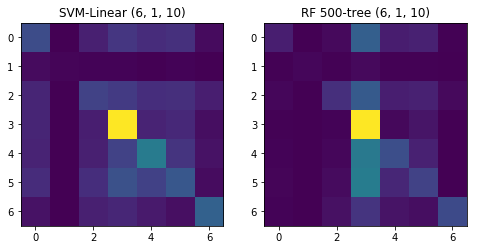

D:\software\anaconda\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


SVM-Linear Accuracy with cellsize=6, blocksize=2, orientationbins=8: 0.45904151574254665
RF 500-tree Accuracy with cellsize=6, blocksize=2, orientationbins=8: 0.4674003900808025


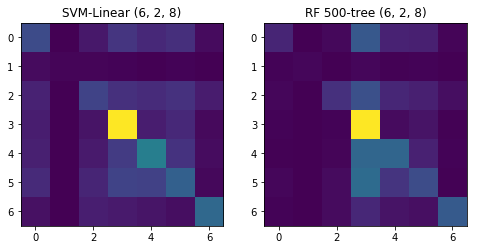

D:\software\anaconda\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


SVM-Linear Accuracy with cellsize=6, blocksize=2, orientationbins=9: 0.4626636946224575
RF 500-tree Accuracy with cellsize=6, blocksize=2, orientationbins=9: 0.46614655893006407


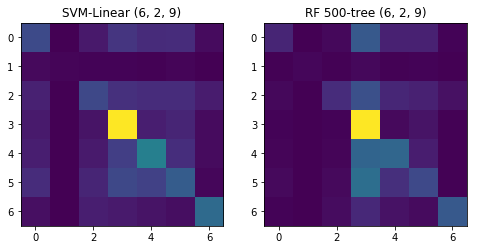

D:\software\anaconda\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


SVM-Linear Accuracy with cellsize=6, blocksize=2, orientationbins=10: 0.4612705488994149
RF 500-tree Accuracy with cellsize=6, blocksize=2, orientationbins=10: 0.4580663137364168


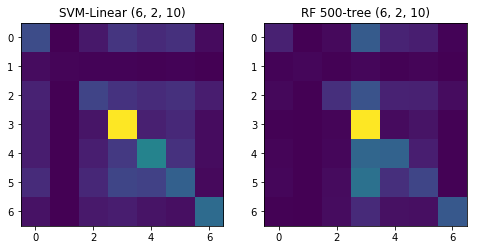

D:\software\anaconda\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


SVM-Linear Accuracy with cellsize=6, blocksize=3, orientationbins=8: 0.45388687656728893
RF 500-tree Accuracy with cellsize=6, blocksize=3, orientationbins=8: 0.47826692672053495


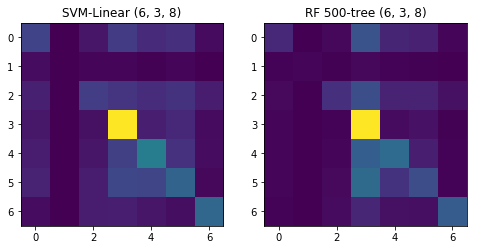

D:\software\anaconda\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


SVM-Linear Accuracy with cellsize=6, blocksize=3, orientationbins=9: 0.45528002229033154
RF 500-tree Accuracy with cellsize=6, blocksize=3, orientationbins=9: 0.4687935358038451


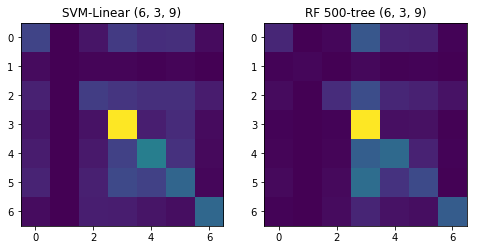

D:\software\anaconda\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


SVM-Linear Accuracy with cellsize=6, blocksize=3, orientationbins=10: 0.45904151574254665
RF 500-tree Accuracy with cellsize=6, blocksize=3, orientationbins=10: 0.46712176093619395


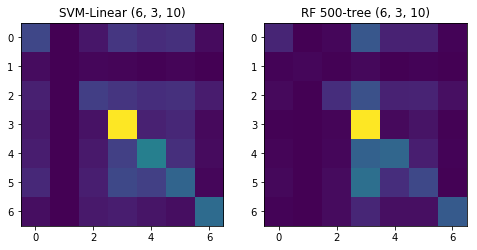

D:\software\anaconda\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


SVM-Linear Accuracy with cellsize=8, blocksize=1, orientationbins=8: 0.4172471440512678
RF 500-tree Accuracy with cellsize=8, blocksize=1, orientationbins=8: 0.4593201448871552


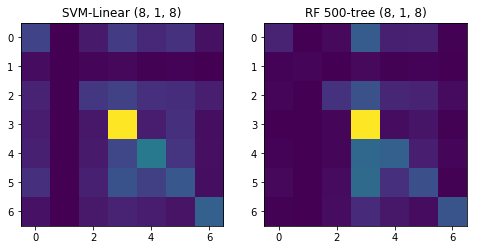

D:\software\anaconda\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


SVM-Linear Accuracy with cellsize=8, blocksize=1, orientationbins=9: 0.41209250487601
RF 500-tree Accuracy with cellsize=8, blocksize=1, orientationbins=9: 0.4582056283087211


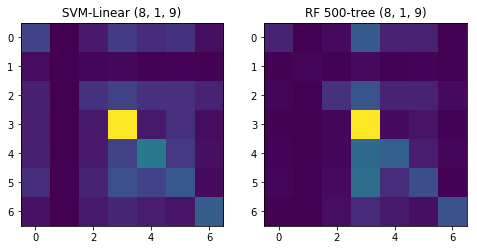

D:\software\anaconda\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


SVM-Linear Accuracy with cellsize=8, blocksize=1, orientationbins=10: 0.41571468375592086
RF 500-tree Accuracy with cellsize=8, blocksize=1, orientationbins=10: 0.4494288102535525


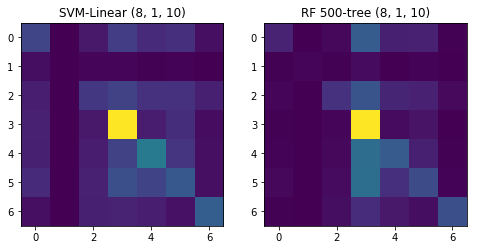

D:\software\anaconda\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


SVM-Linear Accuracy with cellsize=8, blocksize=2, orientationbins=8: 0.4449707439398161
RF 500-tree Accuracy with cellsize=8, blocksize=2, orientationbins=8: 0.48202842017275005


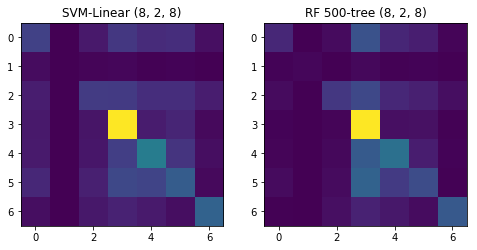

D:\software\anaconda\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


SVM-Linear Accuracy with cellsize=8, blocksize=2, orientationbins=9: 0.44483142936751185
RF 500-tree Accuracy with cellsize=8, blocksize=2, orientationbins=9: 0.48133184731122874


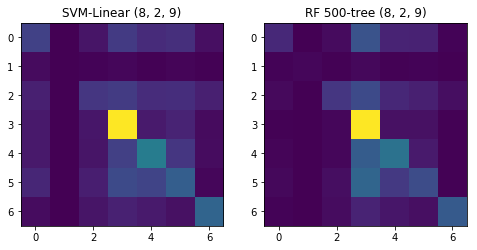

D:\software\anaconda\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


SVM-Linear Accuracy with cellsize=8, blocksize=2, orientationbins=10: 0.4460852605182502
RF 500-tree Accuracy with cellsize=8, blocksize=2, orientationbins=10: 0.4786848704374478


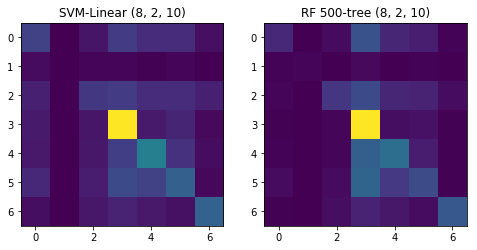

D:\software\anaconda\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


SVM-Linear Accuracy with cellsize=8, blocksize=3, orientationbins=8: 0.4439955419336863
RF 500-tree Accuracy with cellsize=8, blocksize=3, orientationbins=8: 0.4817497910281415


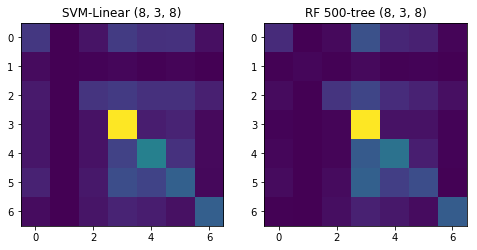

D:\software\anaconda\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


SVM-Linear Accuracy with cellsize=8, blocksize=3, orientationbins=9: 0.44246308163833936
RF 500-tree Accuracy with cellsize=8, blocksize=3, orientationbins=9: 0.4779882975759264


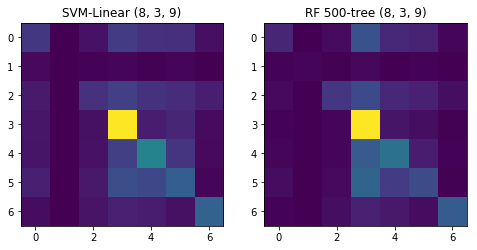

D:\software\anaconda\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


SVM-Linear Accuracy with cellsize=8, blocksize=3, orientationbins=10: 0.44357759821677345
RF 500-tree Accuracy with cellsize=8, blocksize=3, orientationbins=10: 0.48161047645583727


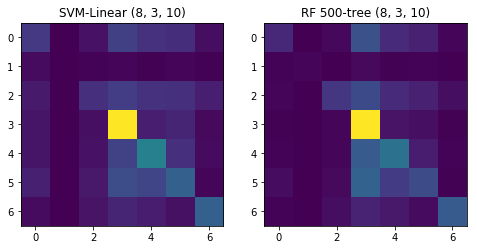

D:\software\anaconda\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


SVM-Linear Accuracy with cellsize=10, blocksize=1, orientationbins=8: 0.36792978545555866
RF 500-tree Accuracy with cellsize=10, blocksize=1, orientationbins=8: 0.4474784062412928


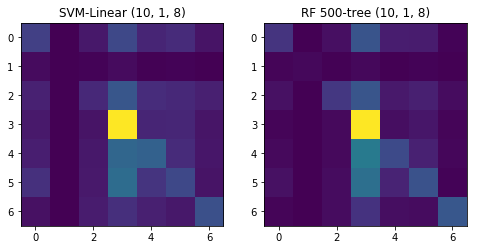

D:\software\anaconda\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


SVM-Linear Accuracy with cellsize=10, blocksize=1, orientationbins=9: 0.36765115631095013
RF 500-tree Accuracy with cellsize=10, blocksize=1, orientationbins=9: 0.44483142936751185


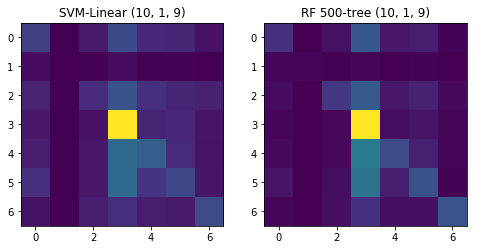

D:\software\anaconda\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


SVM-Linear Accuracy with cellsize=10, blocksize=1, orientationbins=10: 0.37071607690164393
RF 500-tree Accuracy with cellsize=10, blocksize=1, orientationbins=10: 0.4409306213429925


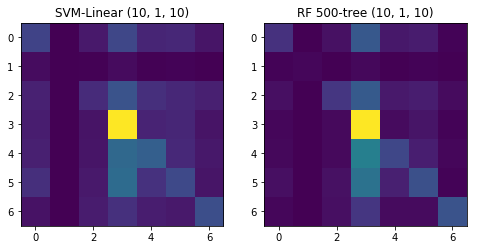

D:\software\anaconda\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


SVM-Linear Accuracy with cellsize=10, blocksize=2, orientationbins=8: 0.4020618556701031
RF 500-tree Accuracy with cellsize=10, blocksize=2, orientationbins=8: 0.4679576483700195


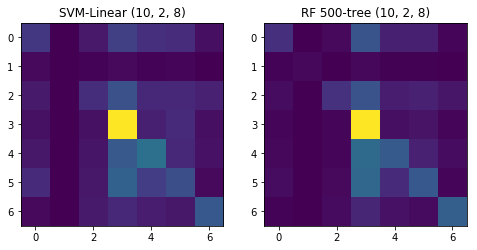

D:\software\anaconda\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


SVM-Linear Accuracy with cellsize=10, blocksize=2, orientationbins=9: 0.40025076623014766
RF 500-tree Accuracy with cellsize=10, blocksize=2, orientationbins=9: 0.465589300640847


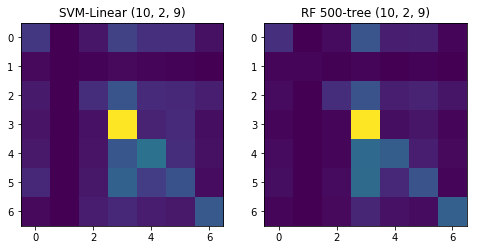

D:\software\anaconda\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


SVM-Linear Accuracy with cellsize=10, blocksize=2, orientationbins=10: 0.4072164948453608
RF 500-tree Accuracy with cellsize=10, blocksize=2, orientationbins=10: 0.4632209529116746


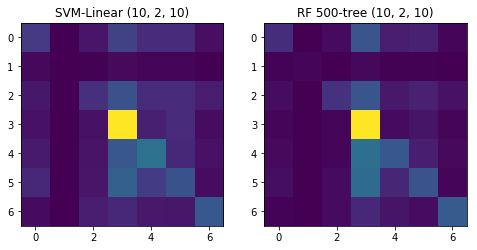

D:\software\anaconda\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


SVM-Linear Accuracy with cellsize=10, blocksize=3, orientationbins=8: 0.38548342156589577
RF 500-tree Accuracy with cellsize=10, blocksize=3, orientationbins=8: 0.47227640011145167


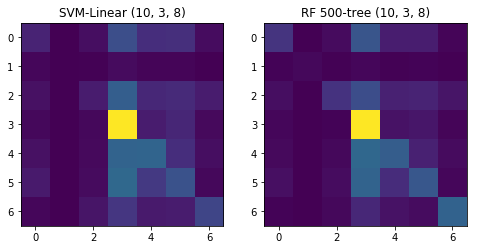

D:\software\anaconda\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


SVM-Linear Accuracy with cellsize=10, blocksize=3, orientationbins=9: 0.381861242685985
RF 500-tree Accuracy with cellsize=10, blocksize=3, orientationbins=9: 0.470883254388409


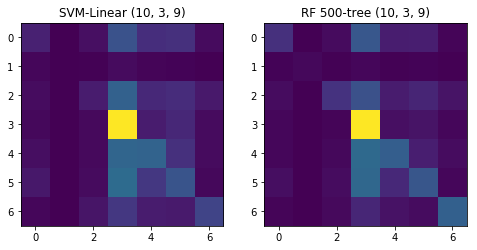

D:\software\anaconda\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


SVM-Linear Accuracy with cellsize=10, blocksize=3, orientationbins=10: 0.38144329896907214
RF 500-tree Accuracy with cellsize=10, blocksize=3, orientationbins=10: 0.4648927277793257


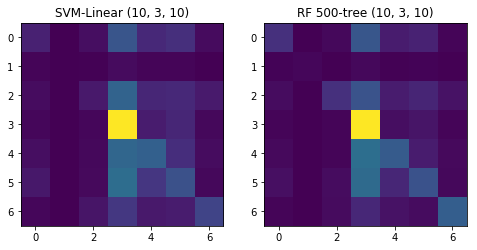

In [23]:
#Exploring different parameters of HoG
svm_linear_hogtest = svm.SVC(kernel='linear', gamma='scale')
rf500_hogtest = RandomForestClassifier(n_estimators=500, criterion='entropy')
variedHoGpredictions = np.empty((8, 2, 7178))   # saved in order of for loop

index = 0
for cellsize in [6, 8, 10]:
    for blocksize in [1, 2, 3]:
        for orientationbins in [8, 9, 10]:
            hogIterFeatures = np.asarray([hog(image, orientations=orientationbins, pixels_per_cell=(cellsize,cellsize), cells_per_block=(blocksize,blocksize)) for image in training])
            testHogIterFeatures = np.asarray([hog(testImage, orientations=orientationbins, pixels_per_cell=(cellsize,cellsize), cells_per_block=(blocksize,blocksize)) for testImage in testing])
            
            svm_linear_hogtest.fit(hogIterFeatures, Y_trn)
            rf500_hogtest.fit(hogIterFeatures, Y_trn)
            
            svm_linear_hogtest_predictions = svm_linear_hogtest.predict(testHogIterFeatures)
            rf500_hogtest_predictions = rf500_hogtest.predict(testHogIterFeatures)
            variedHoGpredictions[index][0] = svm_linear_hogtest_predictions
            variedHoGpredictions[index][1] = rf500_hogtest_predictions
            print('SVM-Linear Accuracy with cellsize={}, blocksize={}, orientationbins={}: {}'.format(cellsize, blocksize, orientationbins, accuracy_score(Y_test, svm_linear_hogtest_predictions)))
            print('RF 500-tree Accuracy with cellsize={}, blocksize={}, orientationbins={}: {}'.format(cellsize, blocksize, orientationbins, accuracy_score(Y_test, rf500_hogtest_predictions)))
            plt.figure(figsize=(8, 4))
            plt.subplot(121), plt.imshow(confusion_matrix(Y_test, svm_linear_hogtest_predictions)), plt.title('SVM-Linear ({}, {}, {})'.format(cellsize, blocksize, orientationbins))
            plt.subplot(122), plt.imshow(confusion_matrix(Y_test, rf500_hogtest_predictions)), plt.title('RF 500-tree ({}, {}, {})'.format(cellsize, blocksize, orientationbins))
            plt.show()